In [1]:
import json
import time
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from twelvedata import TDClient

In [3]:
API_KEY = #...#
td = TDClient(apikey=API_KEY)

def fetch_exchange_rates(currencies):
    """
    Fetch exchange rates for only one direction and compute inverses.
    """
    exchange_rates = {}

    pairs = [] # currency pairs to fetch
    for i in range(len(currencies)):
        for j in range(i + 1, len(currencies)):  # bottom left triangle of nxn matrix
            pairs.append(f"{currencies[i]}/{currencies[j]}")

    batch_size = 8  # TwelveData free plan rate limit
    num_batches = len(pairs) // batch_size + (1 if len(pairs) % batch_size != 0 else 0) # batching requests

    print(f"Fetching {len(pairs)} forex pairs in {num_batches} batches (1 batch per minute)...")

    for i in range(0, len(pairs), batch_size):
        
        batch = pairs[i : i + batch_size]
        print(f"Fetching batch {i // batch_size + 1}/{num_batches}: {batch}")

        try:
        
            prices = td.price(symbol=batch).as_json()

            for pair, data in prices.items():
                base, quote = pair.split("/")
                rate = float(data["price"])

                # adjusting JPY-based quotes
                if base == "JPY":
                    rate /= 100 
                if quote == "JPY":
                    rate *= 100

                if base not in exchange_rates:
                    exchange_rates[base] = {}
                if quote not in exchange_rates:
                    exchange_rates[quote] = {}
                
                exchange_rates[base][quote] = rate     # saving direct exchange rate
                exchange_rates[quote][base] = 1 / rate # compute and save the inverse rate

            # saving progress in case of failures
            with open("forex_rates.json", "w") as f:
                json.dump(exchange_rates, f, indent=4)

            print("Batch saved successfully.")

        except Exception as e:
            print(f"Error fetching batch: {e}")

        # wait to avoid exceeding the rate limit
        if i + batch_size < len(pairs):
            print("Waiting 60 seconds before next batch...")
            time.sleep(60)

    print("All exchange rates successfully retrieved and saved.")
    return exchange_rates


In [5]:
currencies = ["USD", "EUR", "GBP", "CHF", "CNY", "NOK", "DKK", "SEK", "AUD", "NZD", "CAD"]
exchange_rates = fetch_exchange_rates(currencies)

Fetching 55 forex pairs in 7 batches (1 batch per minute)...
Fetching batch 1/7: ['USD/EUR', 'USD/GBP', 'USD/CHF', 'USD/CNY', 'USD/NOK', 'USD/DKK', 'USD/SEK', 'USD/AUD']
Batch saved successfully.
Waiting 60 seconds before next batch...
Fetching batch 2/7: ['USD/NZD', 'USD/CAD', 'EUR/GBP', 'EUR/CHF', 'EUR/CNY', 'EUR/NOK', 'EUR/DKK', 'EUR/SEK']
Batch saved successfully.
Waiting 60 seconds before next batch...
Fetching batch 3/7: ['EUR/AUD', 'EUR/NZD', 'EUR/CAD', 'GBP/CHF', 'GBP/CNY', 'GBP/NOK', 'GBP/DKK', 'GBP/SEK']
Batch saved successfully.
Waiting 60 seconds before next batch...
Fetching batch 4/7: ['GBP/AUD', 'GBP/NZD', 'GBP/CAD', 'CHF/CNY', 'CHF/NOK', 'CHF/DKK', 'CHF/SEK', 'CHF/AUD']
Batch saved successfully.
Waiting 60 seconds before next batch...
Fetching batch 5/7: ['CHF/NZD', 'CHF/CAD', 'CNY/NOK', 'CNY/DKK', 'CNY/SEK', 'CNY/AUD', 'CNY/NZD', 'CNY/CAD']
Batch saved successfully.
Waiting 60 seconds before next batch...
Fetching batch 6/7: ['NOK/DKK', 'NOK/SEK', 'NOK/AUD', 'NOK/NZD',

In [7]:
print("\nExchange Rates:")
print(json.dumps(exchange_rates, indent=4))


Exchange Rates:
{
    "USD": {
        "EUR": 0.9533,
        "GBP": 0.7874,
        "CHF": 0.89556,
        "CNY": 7.2835,
        "NOK": 11.20401,
        "DKK": 7.11154,
        "SEK": 10.5279,
        "AUD": 1.61098,
        "NZD": 1.7825,
        "CAD": 1.4478
    },
    "EUR": {
        "USD": 1.0489877268435959,
        "GBP": 0.82575,
        "CHF": 0.9392,
        "CNY": 7.6383,
        "NOK": 11.74914,
        "DKK": 7.45775,
        "SEK": 11.03967,
        "AUD": 1.68956,
        "NZD": 1.86996,
        "CAD": 1.51879
    },
    "GBP": {
        "USD": 1.27000254000508,
        "EUR": 1.2110202845897668,
        "CHF": 1.13728,
        "CNY": 9.2499,
        "NOK": 14.22765,
        "DKK": 9.0297,
        "SEK": 13.3674,
        "AUD": 2.04597,
        "NZD": 2.26466,
        "CAD": 1.83901
    },
    "CHF": {
        "USD": 1.116619768636384,
        "EUR": 1.0647359454855196,
        "GBP": 0.8792909397861564,
        "CNY": 8.132,
        "NOK": 12.5134,
        "DKK": 

In [13]:
def load_exchange_rates(filename="forex_rates.json"):
    """
    Load exchange rates from a saved JSON file.
    """
    with open(filename, "r") as f:
        return json.load(f)

def construct_graph(exchange_rates):
    """
    Construct a forex graph with -log(exchange rates) as edge weights.
    """
    graph = {}
    
    for base in exchange_rates:
        graph[base] = {}
        for quote, rate in exchange_rates[base].items():
            graph[base][quote] = -np.log(rate)  # negative log transform

    return graph, exchange_rates  # return both graph and original rates

def visualize_fxr_graph(graph, exchange_rates):
    """
    Visualize the fx rates graph using NetworkX.
    """
    G = nx.DiGraph()

    for base in graph:
        for quote, weight in graph[base].items():
            G.add_edge(base, quote, weight=exchange_rates[base][quote])  # using original rates for clarity

    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G, seed=42, k=10)
    edge_labels = {(u, v): f"{d['weight']:.4f}" for u, v, d in G.edges(data=True)}

    nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", font_size=10, node_size=3000)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.title("Fx Rates Graph")
    plt.show()

def bellman_ford(graph, exchange_rates, start_currency):
    """
    Runs Bellman-Ford to detect arbitrage cycles.
    
    graph: Forex graph where edges are -log(exchange rates).
    exchange_rates: Original exchange rates to be used for profit calculation.
    start_currency: Arbitrary starting node.
    Arbitrage cycle and its profit value if found, else None.
    """
    
    currencies = list(graph.keys())
    dist = {currency: float("inf") for currency in currencies}
    parent = {currency: None for currency in currencies}
    dist[start_currency] = 0

    # Relax edges |V|-1 times
    for _ in range(len(currencies) - 1):
        for base in graph:
            for quote, weight in graph[base].items():
                if dist[base] + weight < dist[quote]:
                    dist[quote] = dist[base] + weight
                    parent[quote] = base

    # Check for negative cycles
    for base in graph:
        for quote, weight in graph[base].items():
            if dist[base] + weight < dist[quote]:
                
                # negative cycle
                arbitrage_cycle = []
                visited = set()
                curr = quote

                for _ in range(len(currencies)):
                    curr = parent[curr] # tracing back via parents

                cycle_start = curr
                while True:
                    arbitrage_cycle.append(curr)
                    curr = parent[curr]
                    if curr == cycle_start:  # complete cycle
                        break
                
                arbitrage_cycle.append(cycle_start)  # close the cycle
                arbitrage_cycle.reverse()

                # calculate arbitrage profit using correct rates
                profit = compute_arbitrage_profit(exchange_rates, arbitrage_cycle)

                print("Arbitrage Opportunity Found!")
                print("Arbitrage Path:", " → ".join(arbitrage_cycle))
                print(f"Starting with $1 in {arbitrage_cycle[0]}, you end with ${profit:.6f}")

                return arbitrage_cycle, profit

    print("No arbitrage opportunity detected.")
    return None, None

def compute_arbitrage_profit(exchange_rates, cycle):
    """
    Compute profit from following an arbitrage cycle, starting with $1.
    """
    amount = 1.0
    print("\nExchange steps for profit calculation:")

    for i in range(len(cycle) - 1):
        base, quote = cycle[i], cycle[i + 1]
        rate = exchange_rates[base][quote]

        print(f"{base} → {quote}: Rate = {rate:.6f}, Amount = {amount:.6f} → {amount * rate:.6f}")
        amount *= rate  # apply rate

    return amount


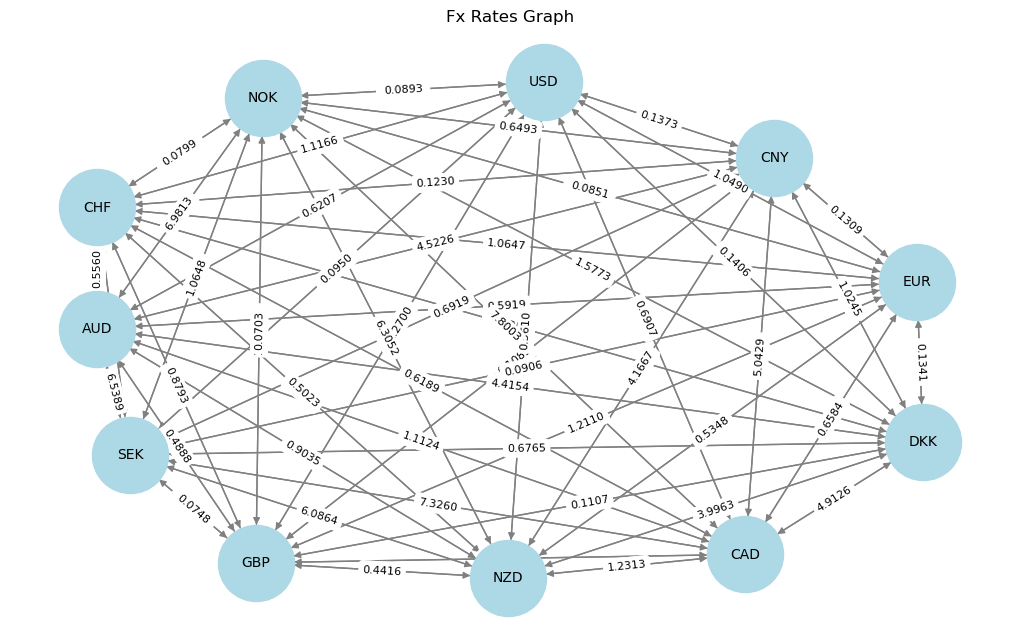


Exchange steps for profit calculation:
CAD → NZD: Rate = 1.231330, Amount = 1.000000 → 1.231330
NZD → SEK: Rate = 6.086427, Amount = 1.231330 → 7.494400
SEK → AUD: Rate = 0.152930, Amount = 7.494400 → 1.146119
AUD → CAD: Rate = 0.898980, Amount = 1.146119 → 1.030338
Arbitrage Opportunity Found!
Arbitrage Path: CAD → NZD → SEK → AUD → CAD
Starting with $1 in CAD, you end with $1.030338


In [15]:
# Construct graph
forex_graph, original_rates = construct_graph(exchange_rates)
visualize_fxr_graph(forex_graph, original_rates)

# search for arbitrage opportunity
start_currency = "USD"
arbitrage_cycle, profit = bellman_ford(forex_graph, original_rates, start_currency)